# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from tqdm import tqdm

# Загружаем разметку

In [3]:
label_vocab = {
    "ALB": 0,
    "BET": 1,
    "DOL": 2,
    "LAG": 3,
    "NoF": 4,
    "OTHER": 5,
    "SHARK": 6,
    "YFT": 7
}

In [4]:
itol = {v:k for k,v in label_vocab.items()}

In [5]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = './data/fish/train'

def load_boxes():
    boxes = dict()
    for path in glob('./data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                annotation['label'] = label_vocab[label.upper()]       # добавим таргет как номер рыбины
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
    
    print("scales: ", scale_x, scale_y)
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [6]:
boxes = load_boxes()  # разметка детекций

In [7]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,yft,734
1,alb,1719
2,bet,200
3,lag,67
4,dol,117
5,shark,176


scales:  1.0 1.0


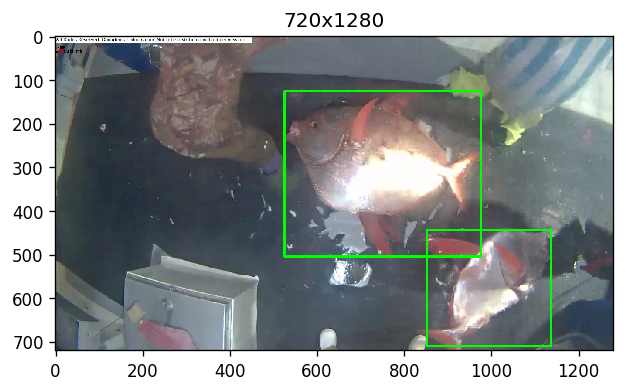

In [8]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['lag'][17])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

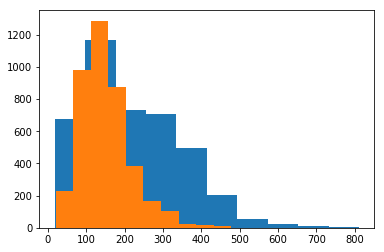

In [9]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [10]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

In [11]:
# Размерность тензора признаков
print(feature_tensor.shape)

(?, 23, 37, 512)


# Сетка якорей (anchor grid)

In [12]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [13]:
print("Размерность тензора признаков: {}".format(FEATURE_SHAPE))
print("Каждый пиксель тензора признаков соответствует n пикселям исходного изображения:\n\tпо вертикали:\t{:.3f}\n\tпо горизонтали:\t{:.3f}".format(GRID_STEP_H, GRID_STEP_W))
print("Центры сетки в пикселях исходного изображения, соответствующие пикселям тензора признаков:\n{}".format(ANCHOR_CENTERS))

Размерность тензора признаков: (23, 37)
Каждый пиксель тензора признаков соответствует n пикселям исходного изображения:
	по вертикали:	32.609
	по горизонтали:	32.432
Центры сетки в пикселях исходного изображения, соответствующие пикселям тензора признаков:
[[[  16.30434783   16.30434783   16.30434783 ...   16.30434783
     16.30434783   16.30434783]
  [  48.91304348   48.91304348   48.91304348 ...   48.91304348
     48.91304348   48.91304348]
  [  81.52173913   81.52173913   81.52173913 ...   81.52173913
     81.52173913   81.52173913]
  ...
  [ 668.47826087  668.47826087  668.47826087 ...  668.47826087
    668.47826087  668.47826087]
  [ 701.08695652  701.08695652  701.08695652 ...  701.08695652
    701.08695652  701.08695652]
  [ 733.69565217  733.69565217  733.69565217 ...  733.69565217
    733.69565217  733.69565217]]

 [[  16.21621622   48.64864865   81.08108108 ... 1118.91891892
   1151.35135135 1183.78378378]
  [  16.21621622   48.64864865   81.08108108 ... 1118.91891892
   115

In [14]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    """
    Функция подсчета IoU для боксов: rect и (anchor_x, anchor_y, anchor_w, anchor_h)
    """
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
#         print("Возможные анкоры, отсортированные по убыванию IoU:")
#         for i in scores[:25]:
#             print(i)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

#         print("Оставшиеся после порога по IoU анкоры:", scores)
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

### Валидация енкодинга/декодинга

{'annotations': [{'class': 'rect', 'height': 182.0000000000008, 'width': 322.0000000000015, 'x': 780.0000000000034, 'y': 170.00000000000074}], 'class': 'image', 'filename': './data/fish/train/ALB/img_07223.jpg', 'label': 0}
encoded anchor: [ 1.          0.5297297   0.06231884 -1.1466666  -0.21333334]
[{'x': 780.0000008699058, 'y': 170.00000021703866, 'width': 321.9999969005585, 'height': 182.00000077486038, 'conf': 0.731058573739949}]
scales:  1.0 1.0


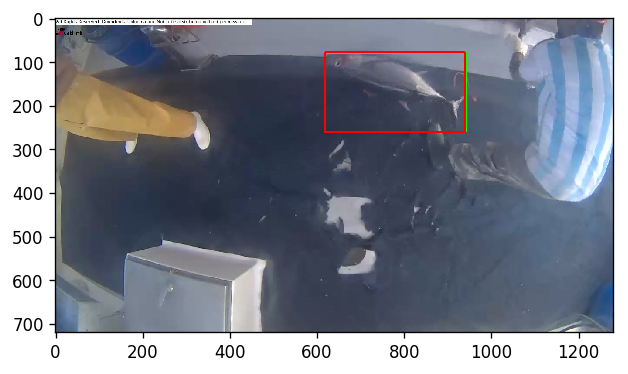

In [15]:
example = boxes['alb'][175]
print(example)

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))
print("encoded anchor:", encoded[encoded != 0])

decoded = decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])
print(decoded)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:10]))

## Функция потерь

In [16]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    # split target tensor into 2 parts: confidence-localization and classification  
    y_true_clf = y_true[...,-8:]
    y_pred_clf = y_pred[...,-8:]
    clf_loss = K.categorical_crossentropy(y_true_clf, y_pred_clf, from_logits=False)
#     clf_loss = keras.losses.categorical_crossentropy(y_true=y_true_clf, y_pred=y_pred_clf)
    
    # rest of the target tensor
    y_true = K.reshape(y_true[...,:-8], (batch_size, -1, 5))
    y_pred = K.reshape(y_pred[...,:-8], (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + clf_loss

## Загрузка данных

In [17]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [18]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                
                # TODO: добавьте one-hot encoding в разметку для классов
                anchors = encode_anchors(boxes[j], img_shape)
                kind_of_fish = to_categorical(boxes[j]['label'], num_classes=len(label_vocab))
                target_tensor = np.reshape(anchors, (anchors.shape[0]*anchors.shape[1]*anchors.shape[2]))
                target_tensor = np.concatenate((target_tensor, kind_of_fish), axis=-1)
                
                y.append(target_tensor)
                X.append(img)
            yield np.array(X), np.array(y)

In [19]:
# Входная размерность (X)
next(data_generator(boxes, 1))[0].shape

(1, 750, 1200, 3)

In [20]:
# Выходная размерность (y)
next(data_generator(boxes, 1))[1].shape

(1, 4263)

In [21]:
next(data_generator(boxes, 1))

(array([[[[ 148.061   ,  137.22101 ,  130.32    ],
          [ 147.061   ,  136.22101 ,  129.32    ],
          [ 150.061   ,  136.22101 ,  128.32    ],
          ...,
          [-100.939   , -100.779   , -123.68    ],
          [-100.939   , -100.779   , -123.68    ],
          [-100.939   , -100.779   , -123.68    ]],
 
         [[ 151.061   ,  138.22101 ,  131.32    ],
          [ 150.061   ,  138.22101 ,  129.32    ],
          [ 151.061   ,  138.22101 ,  130.32    ],
          ...,
          [-100.939   , -100.779   , -123.68    ],
          [-100.939   , -100.779   , -123.68    ],
          [-100.939   , -100.779   , -123.68    ]],
 
         [[ 151.061   ,  136.22101 ,  128.32    ],
          [ 149.061   ,  137.22101 ,  128.32    ],
          [ 150.061   ,  138.22101 ,  129.32    ],
          ...,
          [-100.939   , -100.779   , -123.68    ],
          [-100.939   , -100.779   , -123.68    ],
          [-100.939   , -100.779   , -123.68    ]],
 
         ...,
 
         [[ 

## Добавляем выход детектора

In [22]:
bn_layer = keras.layers.BatchNormalization()(feature_tensor)

# 1. Выходы локализации
output_loc = keras.layers.Conv2D(5,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2',name="Loc_conv")(bn_layer)

output_loc = keras.layers.Flatten()(output_loc)

# TODO: добавьте выходы для классификации детекции
# 2. Выходы классификации

output_clf = keras.layers.Flatten()(bn_layer)
output_clf = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(output_clf)
output_clf = keras.layers.Dropout(0.5)(output_clf)
output_clf = keras.layers.Dense(8,     # число классов
                activation='softmax',  # функция активации  
                name='Softmax'
            )(output_clf)

output = keras.layers.Concatenate()([output_loc, output_clf])


model = keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 750, 1200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 750, 1200, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 750, 1200, 64 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 375, 600, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

## Обучение

In [ ]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics={'conf_loss': confidence_loss})

In [ ]:
batch_size = 10
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    callbacks=[checkpoint])

Epoch 1/10
301/301 [============================>.] - ETA: 0s - loss: 3.1620
Epoch 00001: loss improved from inf to 3.15715, saving model to weights.01-3.157.hdf5
302/301 [==============================] - 213s 707ms/step - loss: 3.1572
Epoch 2/10
301/301 [============================>.] - ETA: 0s - loss: 1.6936
Epoch 00002: loss improved from 3.15715 to 1.69284, saving model to weights.02-1.693.hdf5
302/301 [==============================] - 204s 675ms/step - loss: 1.6928
Epoch 3/10
301/301 [============================>.] - ETA: 0s - loss: 1.4236
Epoch 00003: loss improved from 1.69284 to 1.42272, saving model to weights.03-1.423.hdf5
302/301 [==============================] - 203s 673ms/step - loss: 1.4227
Epoch 4/10
301/301 [============================>.] - ETA: 0s - loss: 1.2368
Epoch 00004: loss improved from 1.42272 to 1.23681, saving model to weights.04-1.237.hdf5
302/301 [==============================] - 203s 673ms/step - loss: 1.2368
Epoch 5/10
301/301 [====================

## Результат работы детектора

scales:  0.9375 1.0416666666666667
Зеленая разметка - ground truth; Красная - predicted
Fish: LAG


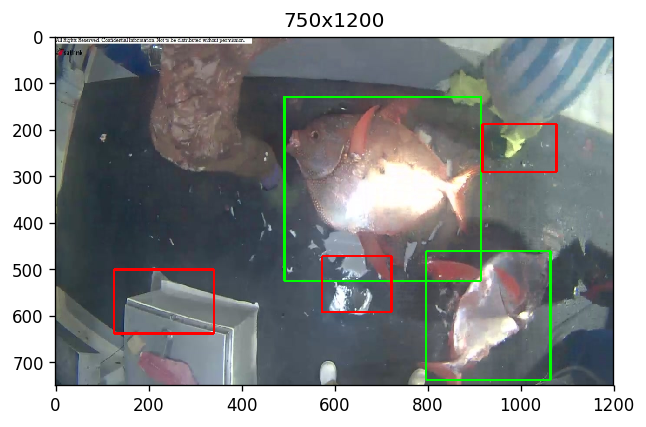

In [41]:
example = boxes['lag'][17]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))[0]

decoded = decode_prediction(np.reshape(pred[:-8], (FEATURE_SHAPE[0], FEATURE_SHAPE[1], 5)), conf_thr=0.)
decoded = sorted(decoded, key=lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:3], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

print("Зеленая разметка - ground truth; Красная - predicted")
print("Fish:", itol[np.argmax(pred[-8:])])

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [ ]:
import pandas as pd

In [ ]:
test_filenames = [path for path in glob('./data/test_stg1/*')] + [path for path in glob('./data/test_stg2/*')]
print("Число примеров в тесте:", len(test_filenames))
assert len(test_filenames) == 13153

In [ ]:
# пример изображения из тестового множества
img = cv2.imread(test_filenames[40], cv2.IMREAD_COLOR)[...,::-1]
plt.imshow(img)

In [ ]:
test_filenames[0]

In [39]:
with open('./submission2.csv', 'wt') as f:
    f.write("image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n")
    for idx, name in tqdm(enumerate(test_filenames)):
        if idx < 1000:
            row = name.split('/')[-1] + ','
        else:
            row = "/".join(name.split('/')[-2:]) + ','
        _, sample_img = load_img(name)
        pred = model.predict(np.array([sample_img,]))[0][-8:]
        str_preds = []
        for x in pred:
            str_preds.append("{:.5f}".format(x))
        row += ",".join(str_preds)
        f.write(row + "\n")

30it [00:02, 11.74it/s]


KeyboardInterrupt: 

In [40]:
!head submission2.csv

image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_05953.jpg,0.98917,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01083
img_03457.jpg,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
img_00858.jpg,0.99999,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001
img_04306.jpg,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
img_06273.jpg,0.86313,0.13481,0.00000,0.00124,0.00000,0.00000,0.00000,0.00081
img_05916.jpg,0.99392,0.00001,0.00000,0.00000,0.00000,0.00000,0.00002,0.00605
img_02574.jpg,0.78358,0.12207,0.00031,0.05278,0.00001,0.00003,0.00330,0.03792
img_06321.jpg,0.10473,0.00001,0.00004,0.00000,0.00000,0.00000,0.00122,0.89399
img_01657.jpg,0.00001,0.00013,0.88809,0.00000,0.00000,0.00000,0.00000,0.11177


In [35]:
# check
!cat submission1.csv | wc -l

13154
